In [1]:
import numpy as np
from PIL import Image
import os
import cv2
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from tqdm import tqdm
import regex as re 
import pandas as pd
import matplotlib.pyplot as plt
import os


In [2]:
# run this cell if running the notebook for the first time. 
def sort_fn(x):
    num1 = re.findall(r"image([\d]+)", x)
    return int(num1[0])

# Sort read in image filenames. 
image_dir = "./images/"
image_filenames = os.listdir(os.path.join(os.getcwd(), "images"))
image_filenames.sort(key= sort_fn)

# Fetch complete image dir. 
image_filenames = [os.path.join(image_dir, i) for i in image_filenames]
len(image_filenames)

labels = [1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1 ,1,1,1,0, 1, 0, 0, 0 ,1,0,1, 0, 0, 1, 0, 0, 1, 1,0, 1, 0,0,1, 1, 1, 1, 1, 1, 1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,1,0,1,1,0,0,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,0,0,1,1,0,1]
pd.DataFrame({"image":image_filenames, "label":labels}).to_csv("train_data.csv", index=False)

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [7]:
class image_Dataset(Dataset):
    # Set output = False if doesn't want the print. 
    def __init__(self, image_filenames, labels):
        super().__init__()
        self.image_filenames = image_filenames
        self.labels = labels
        # Read all images into numpy array. 
        images = []
        for i in self.image_filenames:
            images.append(cv2.imread(i))
        assert len(images) == len(self.image_filenames)
        assert len(images) == len(labels)
        # Convert to tensor and transpose. 
        self.images = torch.tensor(np.array(images)).transpose(1, -1)

        print("The shape of all images: ", self.images.shape)

    def __getitem__(self, i):
        return self.images[i], self.labels[i]

    def __len__(self):
        return len(self.image_filenames)

In [8]:
# Read in the data. 
np.random.seed(888)
df = pd.read_csv("train_data.csv")
temp = df.sample(frac=1)
train_size = 264

train_data = temp.iloc[0 : train_size]
valid_data = temp.iloc[train_size: ]

In [9]:
# Build the dataset. 
batch_size = 16

train_dataset = image_Dataset(train_data["image"].values.tolist(), train_data["label"].values.tolist())
validation_dataset = image_Dataset(valid_data["image"].values.tolist(), valid_data["label"].values.tolist())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

The shape of all images:  torch.Size([264, 3, 500, 500])
The shape of all images:  torch.Size([142, 3, 500, 500])


In [10]:
def load_checkpoint(model, optim, save_name, save_dir = "model_ckpt"):
    save_path = os.path.join(save_dir, save_name)
    assert os.path.exists(save_path), "Path doesn't exist!"
    print("Loading checkpoint...")
    checkpoint = torch.load(save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optim.load_state_dict(checkpoint['optim_state_dict'])
    best_loss = checkpoint['loss']
    print("Done!")

    return best_loss


def train(model, optimizer, train_dataloader, validation_dataloader, criterion, num_epochs = 5, load_from_save =False, save_name = "model0", save_dir = "model_ckpt"):
    
    best_acc = 0.0
    if load_from_save:
        print("Loading the model...")
        best_acc = load_checkpoint(model, optimizer, save_name + ".tar", save_dir)
        print("Done!")
    losses = []
    print(optimizer.param_groups[0]["lr"])
    save_path = os.path.join(save_dir, save_name + ".tar")
    

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for _, (inputs, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            losses.append(loss.item())
            del inputs, labels, pred
        
        print(f"Epoch {epoch} training loss: ", train_loss / len(train_dataloader))
        valid_acc = evaluate(model, validation_dataloader=validation_dataloader, criterion=criterion)

        if valid_acc > best_acc:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            
            best_acc = valid_acc
            state_dict = {
                'model_state_dict': model.state_dict(),
                'optim_state_dict': optimizer.state_dict(),
                'loss': best_acc
            }
            
            torch.save(state_dict, save_path)
            print(f"Saved checkpoint to {save_path}")

        print(f"Best valid accuracy: {best_acc}")
    return losses

def evaluate(model, validation_dataloader, criterion,):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        correct = 0
        for _, (inputs, labels) in tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
            inputs = inputs.float().to(device)
            labels = labels.to(device)
            pred = model(inputs)
            pred_labels = pred.argmax(1)
            correct += (pred_labels == labels).sum().item()
            loss = criterion(pred, labels)
            valid_loss += loss.item()
    acc = correct / len(validation_dataloader) / batch_size
    print("Validation loss: ", valid_loss / len(validation_dataloader))
    print("Validation acc: ", acc)
    return acc

In [ ]:
# Load the model. 
lr = 1e-4
num_epochs = 25
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train(model, optimizer=optimizer, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, criterion=criterion, num_epochs=num_epochs, save_name="model_large2")

plt.plot(losses)
plt.show()

In [14]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

load_checkpoint(model, optimizer, "model_large.tar")
evaluate(model, validation_dataloader=validation_dataloader, criterion=criterion)

Loading checkpoint...
Done!


100%|██████████| 4/4 [00:00<00:00,  7.49it/s]

Validation loss:  0.1884654127061367
Validation acc:  0.75


0.75

In [26]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
losses = train(model, optimizer=optimizer, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, 
                criterion=criterion, num_epochs=10, save_name="model_large", load_from_save=True)

plt.plot(losses)
plt.show()

Loading the model...
Loading checkpoint...
Done!
Done!
0.0001


100%|██████████| 19/19 [00:04<00:00,  3.82it/s]


Epoch 0 training loss:  0.05866755795125898


100%|██████████| 7/7 [00:00<00:00,  9.79it/s]


Validation loss:  0.43247773019330843
Validation acc:  0.7678571428571429
Best valid accuracy: 0.8035714285714286


 79%|███████▉  | 15/19 [00:04<00:01,  3.24it/s]


KeyboardInterrupt: 

In [17]:
# Load the model. 
lr = 1e-4
num_epochs = 10
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

100%|██████████| 19/19 [00:11<00:00,  1.63it/s]


Epoch 0 training loss:  0.646020476755343


100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Validation loss:  0.8629796504974365
Validation acc:  0.5892857142857143
Saved checkpoint to model_ckpt\model0.tar
Best valid accuracy: 0.5892857142857143


100%|██████████| 19/19 [00:11<00:00,  1.64it/s]


Epoch 1 training loss:  0.34912190154979106


100%|██████████| 7/7 [00:01<00:00,  6.80it/s]


Validation loss:  0.902770921587944
Validation acc:  0.6607142857142857
Saved checkpoint to model_ckpt\model0.tar
Best valid accuracy: 0.6607142857142857


100%|██████████| 19/19 [00:12<00:00,  1.54it/s]


Epoch 2 training loss:  0.2239503915372648


100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


Validation loss:  0.6611863587583814
Validation acc:  0.5714285714285714
Best valid accuracy: 0.6607142857142857


100%|██████████| 19/19 [00:12<00:00,  1.57it/s]


Epoch 3 training loss:  0.28638769058804764


100%|██████████| 7/7 [00:01<00:00,  6.37it/s]


Validation loss:  0.5737584419548512
Validation acc:  0.6428571428571429
Best valid accuracy: 0.6607142857142857


100%|██████████| 19/19 [00:11<00:00,  1.72it/s]


Epoch 4 training loss:  0.1837856310762857


100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Validation loss:  0.6643978623407227
Validation acc:  0.7321428571428571
Saved checkpoint to model_ckpt\model0.tar
Best valid accuracy: 0.7321428571428571


100%|██████████| 19/19 [00:10<00:00,  1.75it/s]


Epoch 5 training loss:  0.13166805033228898


100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


Validation loss:  0.7163699120283127
Validation acc:  0.6964285714285714
Best valid accuracy: 0.7321428571428571


100%|██████████| 19/19 [00:11<00:00,  1.71it/s]


Epoch 6 training loss:  0.16116674781139745


100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


Validation loss:  0.441369178039687
Validation acc:  0.7678571428571429
Saved checkpoint to model_ckpt\model0.tar
Best valid accuracy: 0.7678571428571429


100%|██████████| 19/19 [00:12<00:00,  1.58it/s]


Epoch 7 training loss:  0.06482700351625681


100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Validation loss:  0.7288734465837479
Validation acc:  0.5892857142857143
Best valid accuracy: 0.7678571428571429


100%|██████████| 19/19 [00:10<00:00,  1.73it/s]


Epoch 8 training loss:  0.10368854790239741


100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


Validation loss:  0.5721969508699009
Validation acc:  0.6964285714285714
Best valid accuracy: 0.7678571428571429


100%|██████████| 19/19 [00:10<00:00,  1.76it/s]


Epoch 9 training loss:  0.09104350547453291


100%|██████████| 7/7 [00:01<00:00,  6.01it/s]

Validation loss:  0.6478647312947682
Validation acc:  0.6785714285714286
Best valid accuracy: 0.7678571428571429


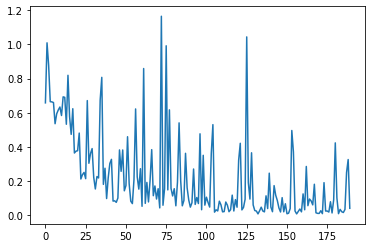

In [18]:
losses = train(model, optimizer=optimizer, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, criterion=criterion, num_epochs=10)

plt.plot(losses)
plt.show()

In [14]:
class ConvNet(nn.Module):
    def __init__(self, input_channels, hidden_channels, fc_dim, kernel_size = 5):
        super().__init__()

        assert type(input_channels) == int
        assert type(hidden_channels) == list 


        # Create a series of Convolutions. 
        models = []
        channels = [input_channels] + hidden_channels
        for i in range(len(channels)- 1):
            in_channel = channels[i]
            out_channel = channels[i + 1]
            temp = nn.Sequential(
                nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size), 
                nn.ReLU(),
                nn.MaxPool2d(2, 2)
            )
            models.append(temp)
        
        self.convs = nn.ModuleList(models)

        self.feed_forward = nn.Sequential(
            nn.Linear(fc_dim, 120), 
            nn.ReLU(),
            nn.Linear(120, 84), 
            nn.ReLU(), 
            nn.Linear(84, 2)
        )

    def forward(self, x):
        for i in self.convs:
            x = i(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.feed_forward(x)
        return x

convnet = ConvNet(input_channels=3, hidden_channels=[6, 16, 32], fc_dim=111392).to(device)

# input: (batch, num_channel, W, H)
# test_input = train_dataset[0:8].float().to(device)
# convnet(test_input)

In [15]:
# Load the model. 
lr = 1e-4
num_epochs = 25
model = convnet


model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses = train(model, optimizer=optimizer, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, criterion=criterion, num_epochs=num_epochs, save_name="model_convnet")

plt.plot(losses)
plt.show()

0.0001


100%|██████████| 17/17 [00:01<00:00, 13.71it/s]


Epoch 0 training loss:  1.8711786235080046


100%|██████████| 9/9 [00:00<00:00, 29.80it/s]


Validation loss:  0.840811292330424
Validation acc:  0.5972222222222222
Saved checkpoint to model_ckpt\model_convnet.tar
Best valid accuracy: 0.5972222222222222


100%|██████████| 17/17 [00:00<00:00, 17.43it/s]


Epoch 1 training loss:  0.7268867527737337


100%|██████████| 9/9 [00:00<00:00, 33.25it/s]


Validation loss:  0.709672040409512
Validation acc:  0.5972222222222222
Best valid accuracy: 0.5972222222222222


100%|██████████| 17/17 [00:00<00:00, 17.74it/s]


Epoch 2 training loss:  0.6327112632639268


100%|██████████| 9/9 [00:00<00:00, 30.16it/s]


Validation loss:  0.6684377127223544
Validation acc:  0.5902777777777778
Best valid accuracy: 0.5972222222222222


100%|██████████| 17/17 [00:00<00:00, 17.88it/s]


Epoch 3 training loss:  0.5524558074334088


100%|██████████| 9/9 [00:00<00:00, 31.87it/s]


Validation loss:  0.6462530030144585
Validation acc:  0.6388888888888888


RuntimeError: File model_ckpt\model_convnet.tar cannot be opened.

In [23]:
train_dataset[0 : 3].shape

torch.Size([3, 3, 500, 500])

In [19]:
np.array(image.convert('RGB'))[0, 0, 0]

211

In [26]:
convnet

ConvNet(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (feed_forward): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)